In [1]:
# Import libaries and illustris library
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
%matplotlib inline
import random
import subroutines.bins as bf
import subroutines.plot_functions as plot_functions
import subroutines.tree_functions as tf
hubble = 0.704

In [3]:
plt.style.use('default')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#load data
snaps=[135,116,103,85]
galData = []
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    galData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta) 17:cluster(1) fil(0) nothing(-1)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('../../Data/WebData/galaxy_web_data.'+str(i)+'.txt'))

galData_ellip = []; galData_disk = [];
webData_ellip = []; webData_disk = [];
for i in range (0,4):
    galData_ellip.append(galData[i][maskEllips(i)])
    webData_ellip.append(webData[i][maskEllips(i)])
    galData_disk.append(galData[i][~maskEllips(i)])
    webData_disk.append(webData[i][~maskEllips(i)])
#load all galaxy data
allgalData = []
for i in range (135,84,-1):
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    allgalData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

allgalData_ellip = []; allgalData_disk = [];
for i in range(0,51):
    allgalData_ellip.append(allgalData[i][allgalData[i][:,14]<0.5]);
    allgalData_disk.append(allgalData[i][allgalData[i][:,14]>0.5]);

In [5]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5);
def maskMass(whichSnap, mass_low, mass_high=50000):
    return ( (mass_high>galData[whichSnap][:,2]) & (galData[whichSnap][:,2]>mass_low) );
def maskMass_data(data, mass_low, mass_high=50000):
    return ( (mass_high>data) & (data>mass_low) );
def maskWeb(whichSnap, webValue):
    return (webData[whichSnap][:,17]==webValue);
def maskWeb_ellip(whichSnap, webValue):
    return (webData_ellip[whichSnap][:,17]==webValue);

# bins is bin list, value means filament or cluster (0 or 1), mass means mass cutoff, indices are which to bin
def fractions_function(bins_1, bins_2, value, mass = 11, index1=17, index2=16):
    if (mass == 0):
        fractions = [];
        for i in range (0,4):
            fractions.append( bf.bin_frac(webData[i][maskEllips(i)][:,index1],
                                      galData[i][maskEllips(i)][:,index2], bins_1, value)
                            )
    else:
        fractions = [[],[]]
        for i in range (0,4):
            # first mass below variable mass
            fractions[0].append( bf.bin_frac(webData[i][maskEllips(i) & (~maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (~maskMass(i,mass))][:,index2], bins_1, value)
                                )
            # then above
            fractions[1].append(bf.bin_frac(webData[i][maskEllips(i) & (maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (maskMass(i,mass))][:,index2], bins_2, value)
                                )
    return fractions;

def redshift_fractions(bcluster=1):
    frac_z = np.zeros((2,2,4))
    for i in range (0,4):
        frac_z[0,:,i] = bf.find_frac(webData[i][maskEllips(i) & (~maskMass(i,11))][:,17],bcluster)[:]
        frac_z[1,:,i] = bf.find_frac(webData[i][maskEllips(i) & (maskMass(i,11))][:,17],bcluster)[:]
    return frac_z

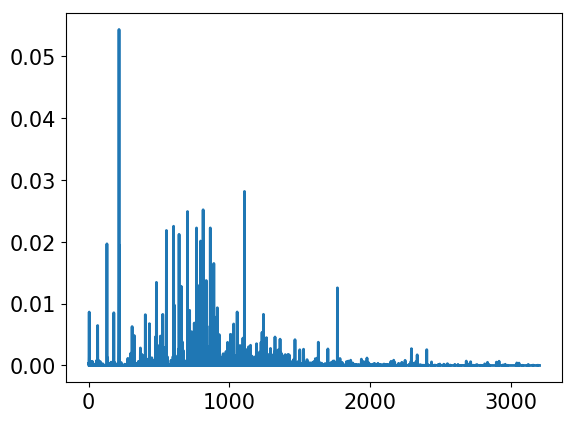

In [95]:
plt.plot(galData_ellip[0][:,19])

High Mass z= 1.0 [ 74.  12.  25.]
Int. Mass z= 1.0 [ 150.   90.   20.]
Low Mass z= 1.0 [  69.  444.   54.]


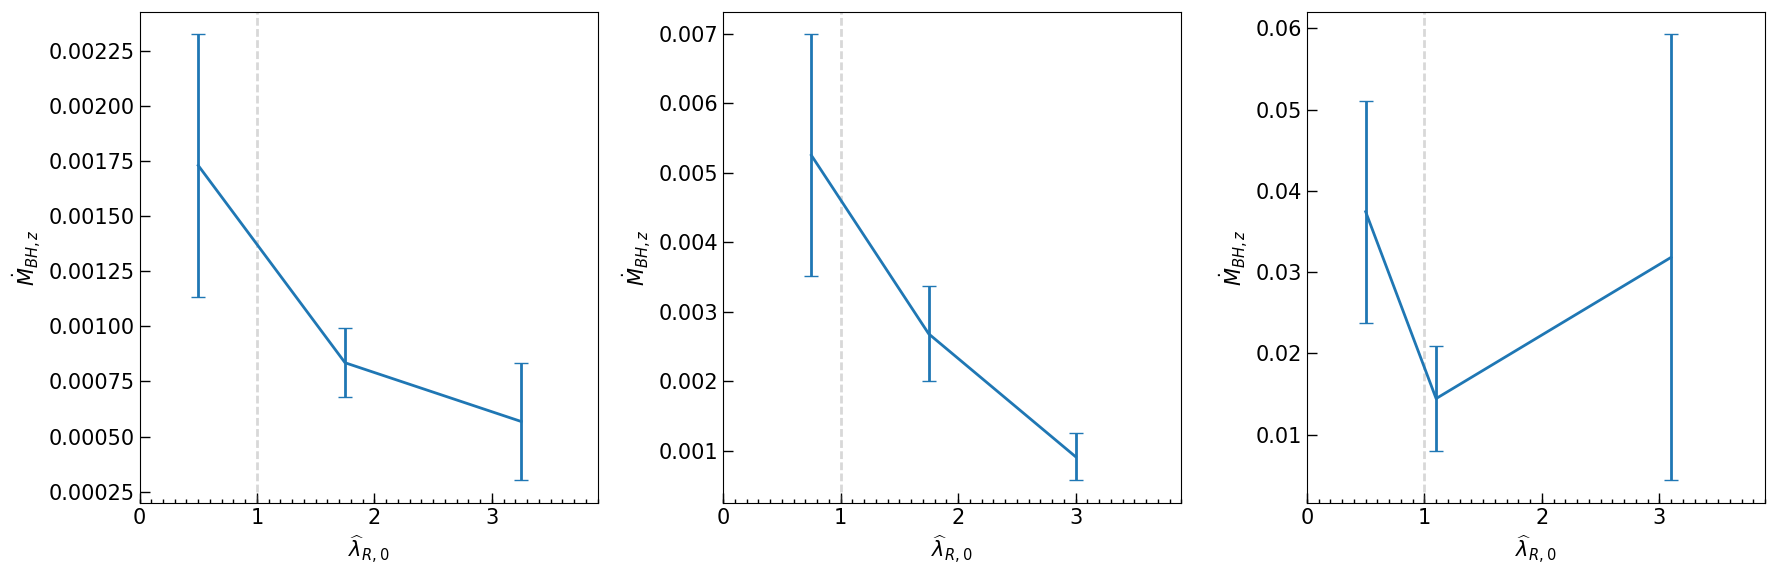

In [215]:
# lambda vs mass for locations in web at z=1 for ellipticals (ellipticals at z=0, progenitors can be anything)
fig = plt.figure(figsize=(18, 6));gs=gridspec.GridSpec(1, 3);
mass = [0,10,32,150]; label = ['Low Mass','Int. Mass', 'High Mass'];
bins = np.array([[0,1,2.5,4],
                 [0,1.5,2,4],
                 [0,1,1.2,5]]); 
for j in [2,1,0]:
    ax = plt.subplot(gs[0,j], facecolor='white');
    for i in [3]:
        output = tf.web_evolution(allgalData, webData,i,0); clean_output = output[~np.isnan(output[:,2])].astype('int64');  
        # clean output of nan and then take all gals that can be traced back
        data_z0 = galData[0][clean_output[:,2]]; data_zn = galData[i][clean_output[:,3]];
        # take all gals that are ellipticals at z=0 and have a certain mass
        mass_mask = maskMass_data(data_z0[:,2],mass[j],mass[j+1]);
        data_zn = data_zn[(data_z0[:,14]<0.5) & mass_mask & (data_z0[:,19]!=0)]; 
        data_z0 = data_z0[(data_z0[:,14]<0.5) & mass_mask & (data_z0[:,19]!=0)];
                
        # bin all of them
        binned_data = bf.bin_data(data_z0[:,16], data_zn[:,19], bins[j])
        ax.errorbar(binned_data[:,6], binned_data[:,1], yerr=binned_data[:,3], fmt='-', label='Bhdot', capsize=5 , color='C0')
        
        minor_ticks_x = np.arange(0, 4, 0.1); ax.set_xticks(minor_ticks_x, minor=True); ax.xaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
        ax.xaxis.set_tick_params(width=1, length=7, direction='in'); ax.yaxis.set_tick_params(width=1, length=7, direction='in');
        ax.set_xlabel(r'$\widehat{\lambda}_{R, 0}$'); ax.set_ylabel(r'$\dot{M}_{BH, z}$');
        ax.set_xlim([0,3.9]);
        ax.axvline(1, color='grey', alpha=0.3, linestyle='--');
        #ax.text(0.7,0.95, label[j],fontsize=15, fontweight='bold', ha='right');
        print(label[j],'z=',i/2-0.5, binned_data[:,5])

plt.tight_layout(); #plt.subplots_adjust(hspace=0, wspace=.0); 
plt.show()

In [208]:

data_size = allgalData_ellip[50].shape[0]
gal_tracer= np.zeros((51,data_size,6))

for ind in range (0,data_size):

    for i in range (50,-1,-1):
        next_index = tf.find_galaxy(allgalData,i,i-1,ind)
        if next_index != -1:
            gal_tracer[i,ind,0] = allgalData[i-1][next_index,16]
            gal_tracer[i,ind,1] = allgalData[i-1][next_index,19]
            gal_tracer[i,ind,2] = allgalData[i-1][next_index,20]
            gal_tracer[i,ind,3] = allgalData[i-1][next_index,14]
            gal_tracer[i,ind,4] = ind
            gal_tracer[i,ind,5] = next_index
            
            

In [209]:
3,6,150,1000,80,12

(3, 6, 1000)

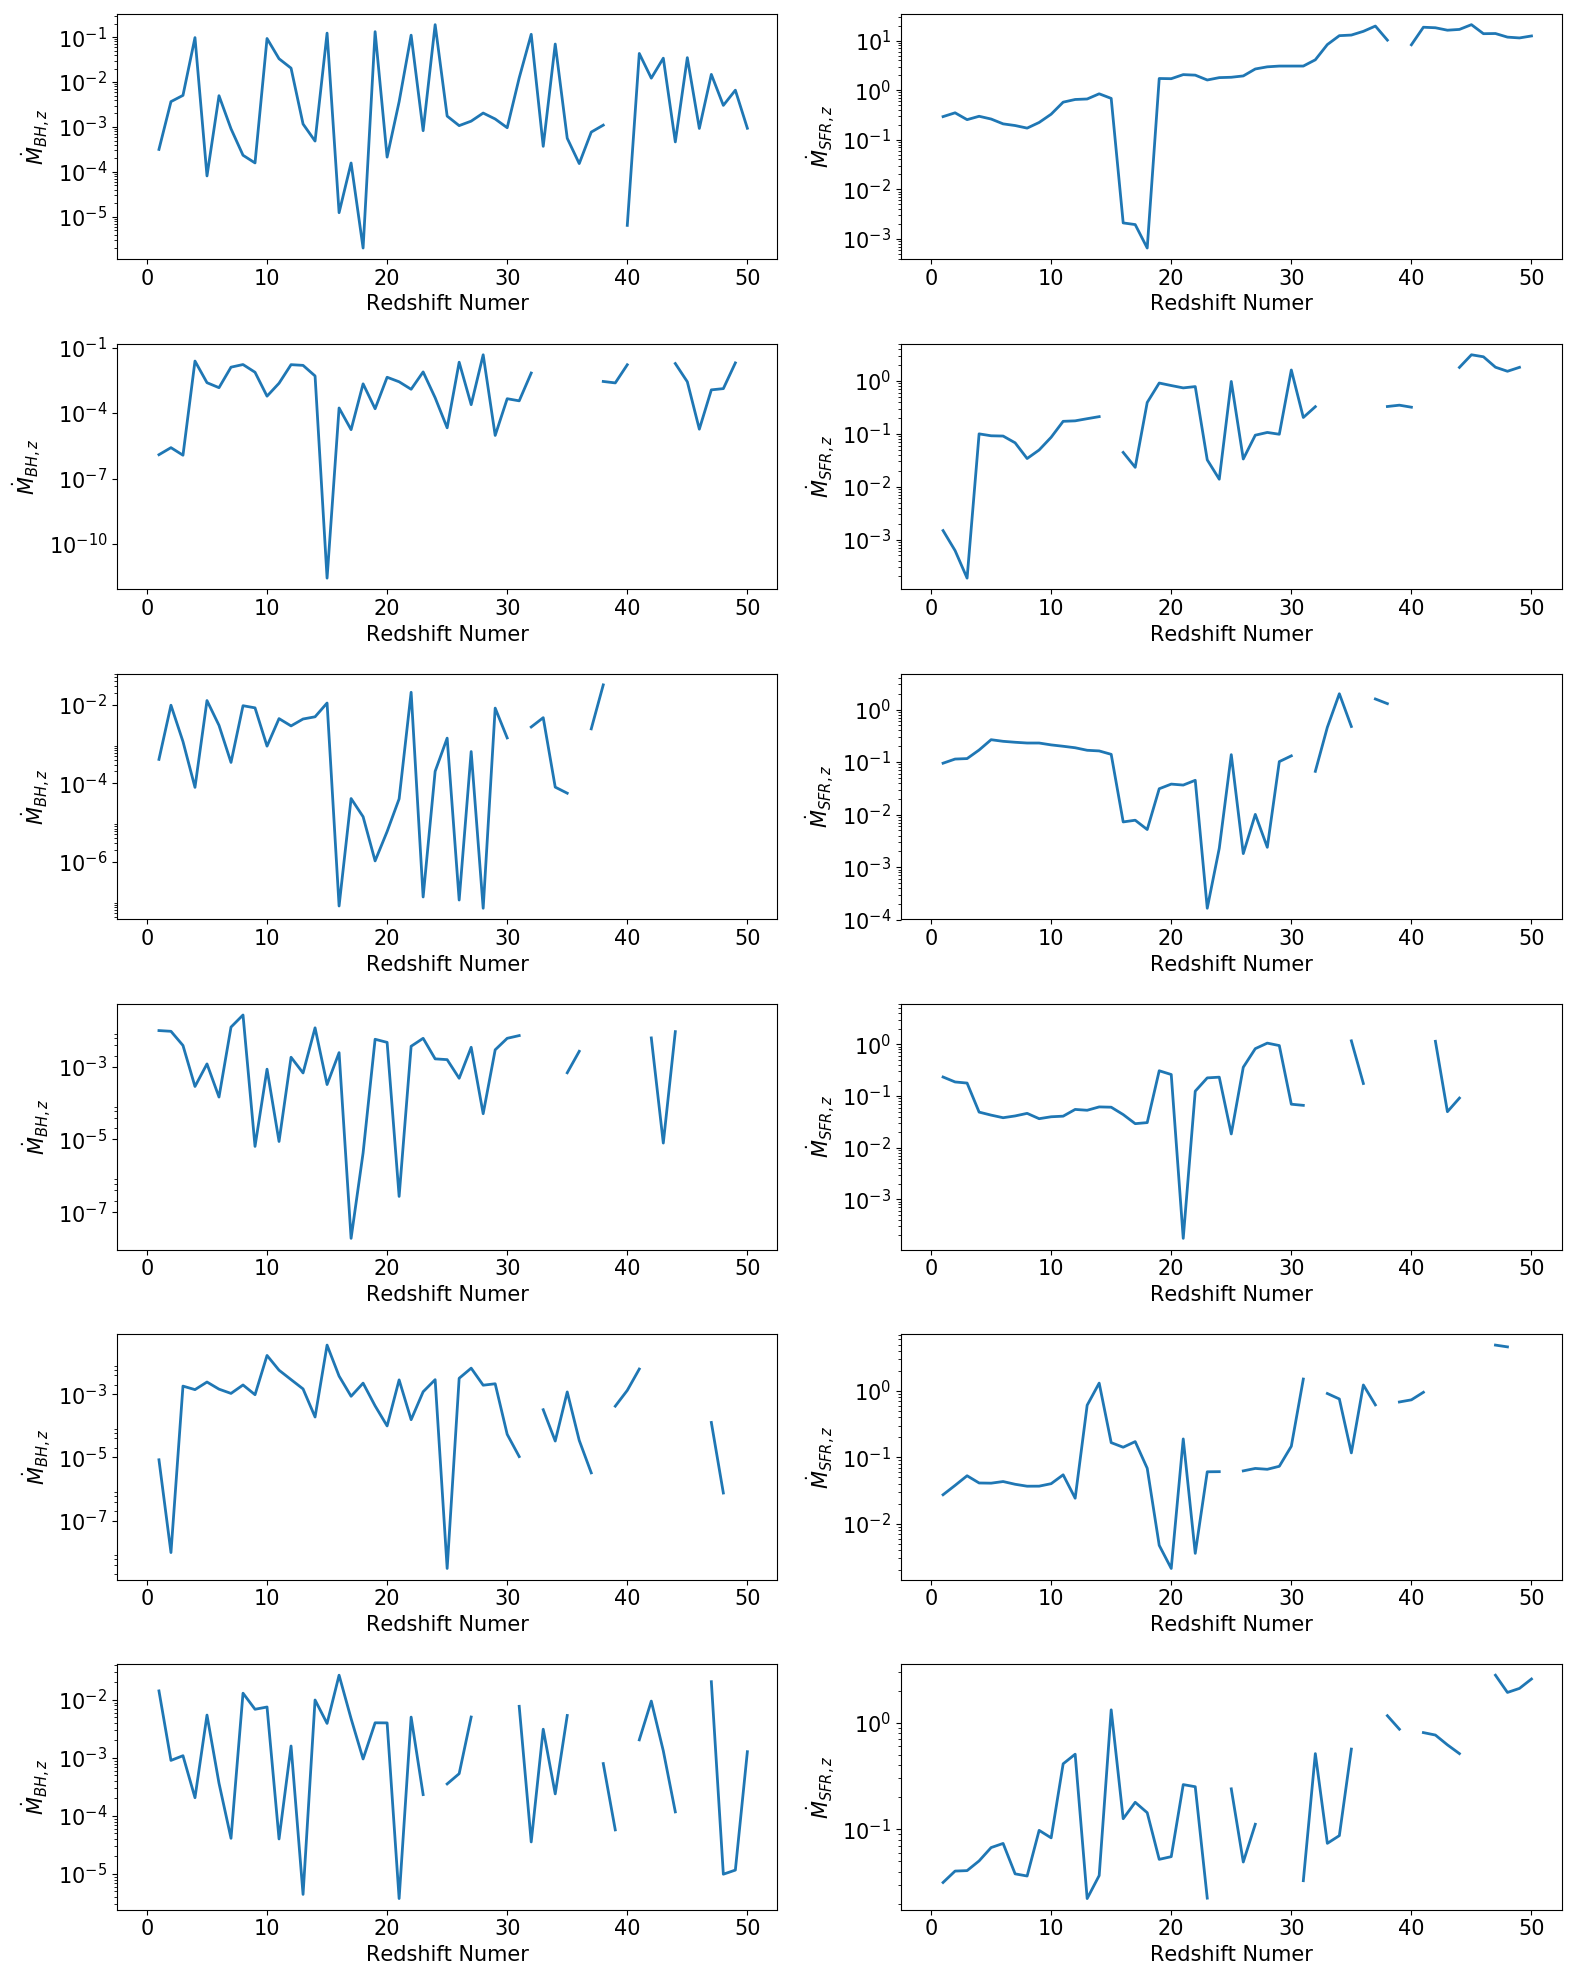

In [229]:
fig = plt.figure(figsize=(16, 20));
gal_ind = [0,1,2,3,4,5]
label =[r'$\dot{M}_{BH, z}$',r'$\dot{M}_{SFR, z}$' ]
gs=gridspec.GridSpec(6, 2)
for i in range (0,len(gal_ind)):
    for j in (0,1):
        ax = plt.subplot(gs[i,j], facecolor='white')
        ax.semilogy(gal_tracer[:,gal_ind[i],j+1])

        ax.set_xlabel('Redshift Numer'); ax.set_ylabel(label[j]);
        plt.tight_layout();

In [ ]:
minor_ticks_x = np.arange(0, 0.7, 0.1); ax.set_xticks(minor_ticks_x, minor=True); ax.xaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
ax.xaxis.set_tick_params(width=1, length=7, direction='in');
ax.yaxis.set_tick_params(width=1, length=7, direction='in');ax.set_yticks(minor_ticks_y, minor=True); ax.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
        ax.set_xlabel(r'$\widehat{\lambda}_{R, 0}$');ax.set_ylim(-0.02,1.02);ax1.set_xlim([0,4]);
        ax.axvline(1, color='grey', alpha=0.3, linestyle='--');
        ax.text(0.7,0.95, label[j],fontsize=15, fontweight='bold', ha='right');
        print(label[j],'z=',i/2-0.5, clust_frac[:,3], fil_frac[:,3], void_frac[:,3])

ax.yaxis.set_tick_params(width=1, length=7, direction='in');ax.set_yticks(minor_ticks_y, minor=True); ax.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
ax = plt.subplot(gs[0,0], facecolor='white'); ax.set_ylabel('Fraction in environment');
minor_ticks_y = np.arange(0, 1, 0.1); ax.set_yticks(minor_ticks_y, minor=True); ax.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');    
plt.tight_layout(); plt.subplots_adjust(hspace=0, wspace=.0); plt.show()